# Validation of HMASR with snow depth stations
## Taylor diagrams

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)
- snow depth stations: [Observational snow depth dataset of the Tibetan Plateau (Version 1.0) (1961-2013)](https://data.tpdc.ac.cn/en/data/72d6dadf-8e1c-458b-b24e-91539042dfe6/)

conda env: `phd_v3`

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load topography

In [2]:
latlim = slice(27, 45)
lonlim = slice(61, 105)

ds = xr.open_dataset('../data/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load stations

In [3]:
path = '../data/in-situ_SD_TP_v1.0_1961-2013/'

df_loc = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013.txt', delimiter='\t')
df_loc.set_index('numb', inplace=True)
df_loc

,prov,name_en,name_cn,latit,longit,elevat
numb,,,,,,
52787,甘肃,S52787,乌鞘岭,37.200000,102.866667,3045.1
52978,甘肃,S52978,夏河,35.200000,102.516667,2929.4
56071,甘肃,S56071,碌曲,34.583333,102.500000,3105.7
56074,甘肃,S56074,玛曲,34.000000,102.083333,3471.4
56080,甘肃,S56080,合作,35.000000,102.900000,2910.0
...,...,...,...,...,...,...
56434,西藏,S56434,察隅,28.650000,97.466667,2327.6
56444,云南,S56444,德钦,28.483333,98.916667,3319.0
56533,云南,S56533,贡山,27.750000,98.666667,1583.3


## Load timseries data 
Saved in `HMASR_validation_with_TPDC_SD_stations.ipynb`

In [4]:
df_station_HMASR = pd.read_csv('data/HMASR_validation_with_TPDC_SD_stations.csv', header=[0, 1], index_col=0, parse_dates=True)
df_station_HMASR = df_station_HMASR.where(df_station_HMASR >= 0) # to avoid some negative values
df_station_HMASR

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56434         56444         56533         56543        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  5.88     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  6.50     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  8.70     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  7.42     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  5.84     0.0   0.0     0.0   0.0     0.0   0.0   

numb         56641        
product    station HMASR  
date                      
1999-10-01     NaN   NaN  
1999-10-02     NaN   NaN  
1999-10-03     NaN   NaN  
1999-10-04     NaN   NaN  
1999-10-05     NaN   NaN  
...            ...   ...  
2013-12-27     NaN   NaN  
2013-12-28     NaN   NaN  
2013-12-29     NaN   NaN  
2013-12-30     NaN   NaN  
2013-12-31     NaN   NaN  

[5206 rows x 204 columns]

### Get >90% time coverage and >1mm in DJFMA
We are going to make some criteria for taking stations, as many stations doesn't have much snow, so for example we can take stations that have a minimum of snow in winter (ex: 1mm threshold) + taking only stations that have more than 90% of data for example.

In [5]:
# Remove stations with less than 90% of data
df_station_HMASR_90 = df_station_HMASR.dropna(thresh=df_station_HMASR.index.size*0.9, axis=1)

temp = df_station_HMASR_90.xs('station', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))

# Take stations having at least 1mm of snow in winter (DJFMA)
mm_mask = temp[winter_mask].mean() > 0.1

# Index of the 62 corresponding stations (> 1mm in winter)
index_1mm = mm_mask[mm_mask == True].index

df_station_HMASR_90_1mm = df_station_HMASR_90[index_1mm]
df_station_HMASR_90_1mm

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56223         56434         56444         56533        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  0.30     0.0  5.88     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  0.28     0.0  6.50     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  0.30     0.0  8.70     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  0.30     0.0  7.42     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  0.30     0.0  5.84     0.0   0.0     0.0   0.0   

numb         56543        
product    station HMASR  
date                      
1999-10-01     0.0   0.0  
1999-10-02     0.0   0.0  
1999-10-03     0.0   0.0  
1999-10-04     0.0   0.0  
1999-10-05     0.0   0.0  
...            ...   ...  
2013-12-27     0.0   0.0  
2013-12-28     0.0   0.0  
2013-12-29     0.0   0.0  
2013-12-30     0.0   0.0  
2013-12-31     0.0   0.0  

[5206 rows x 124 columns]

## Taylor diagram
The Taylor diagrams were made thanks to the Python implementation of Yannick Copin (https://gist.github.com/ycopin/3342888; https://doi.org/10.5281/zenodo.5548061, Copin, 2012).

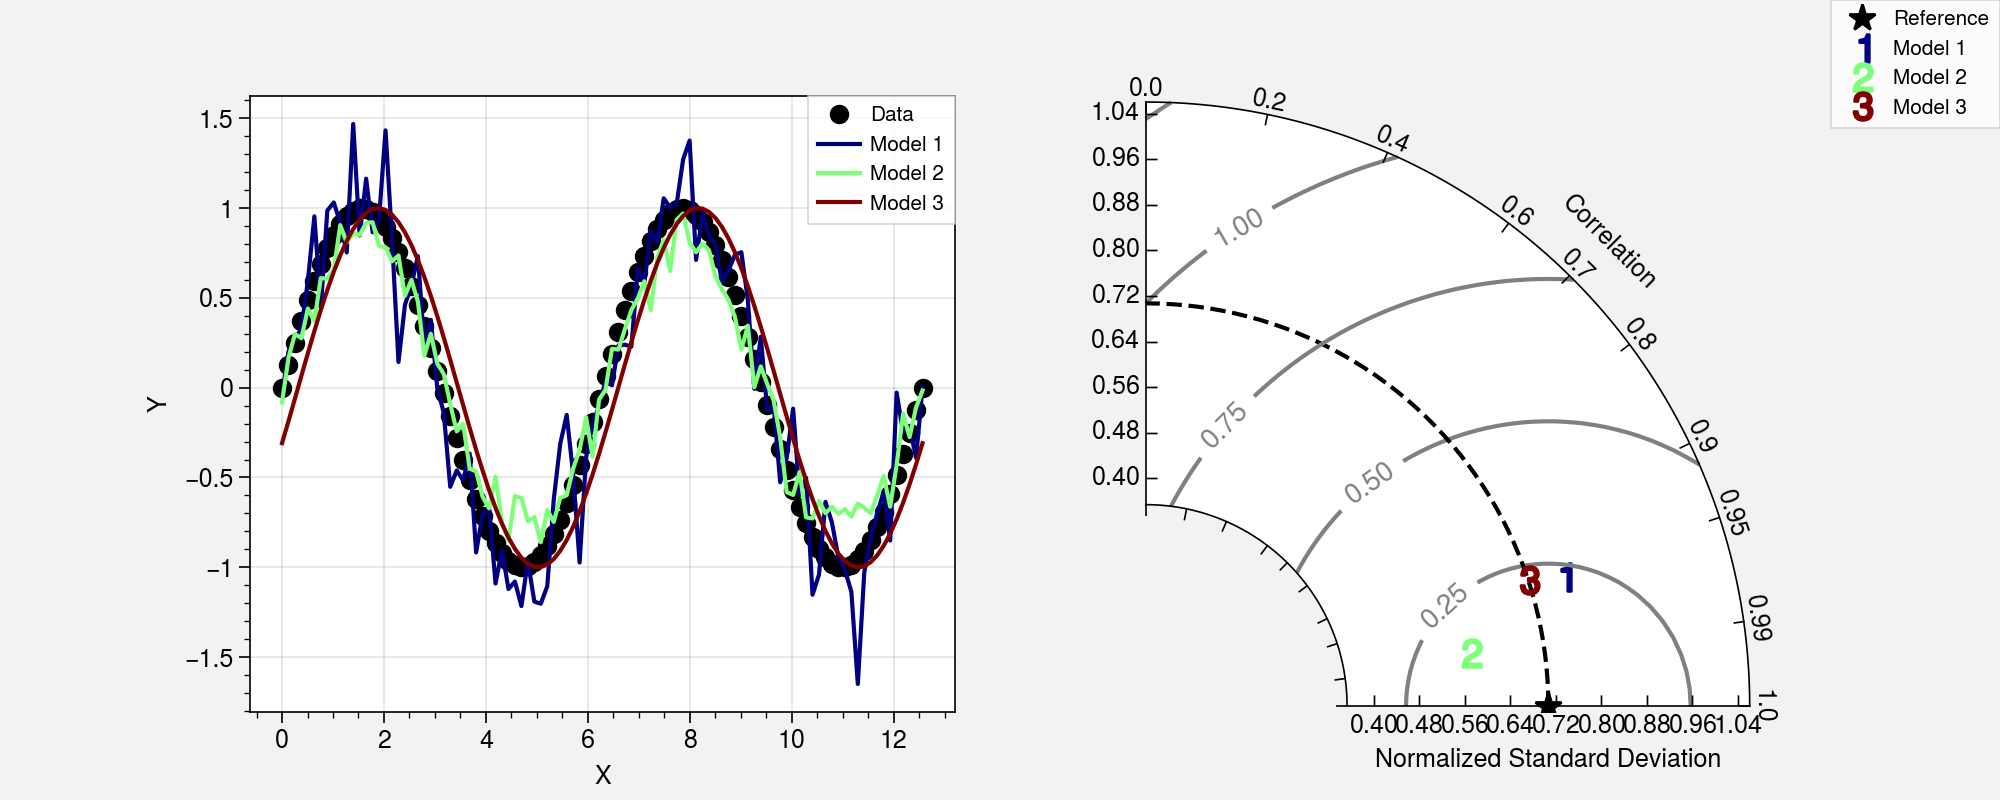

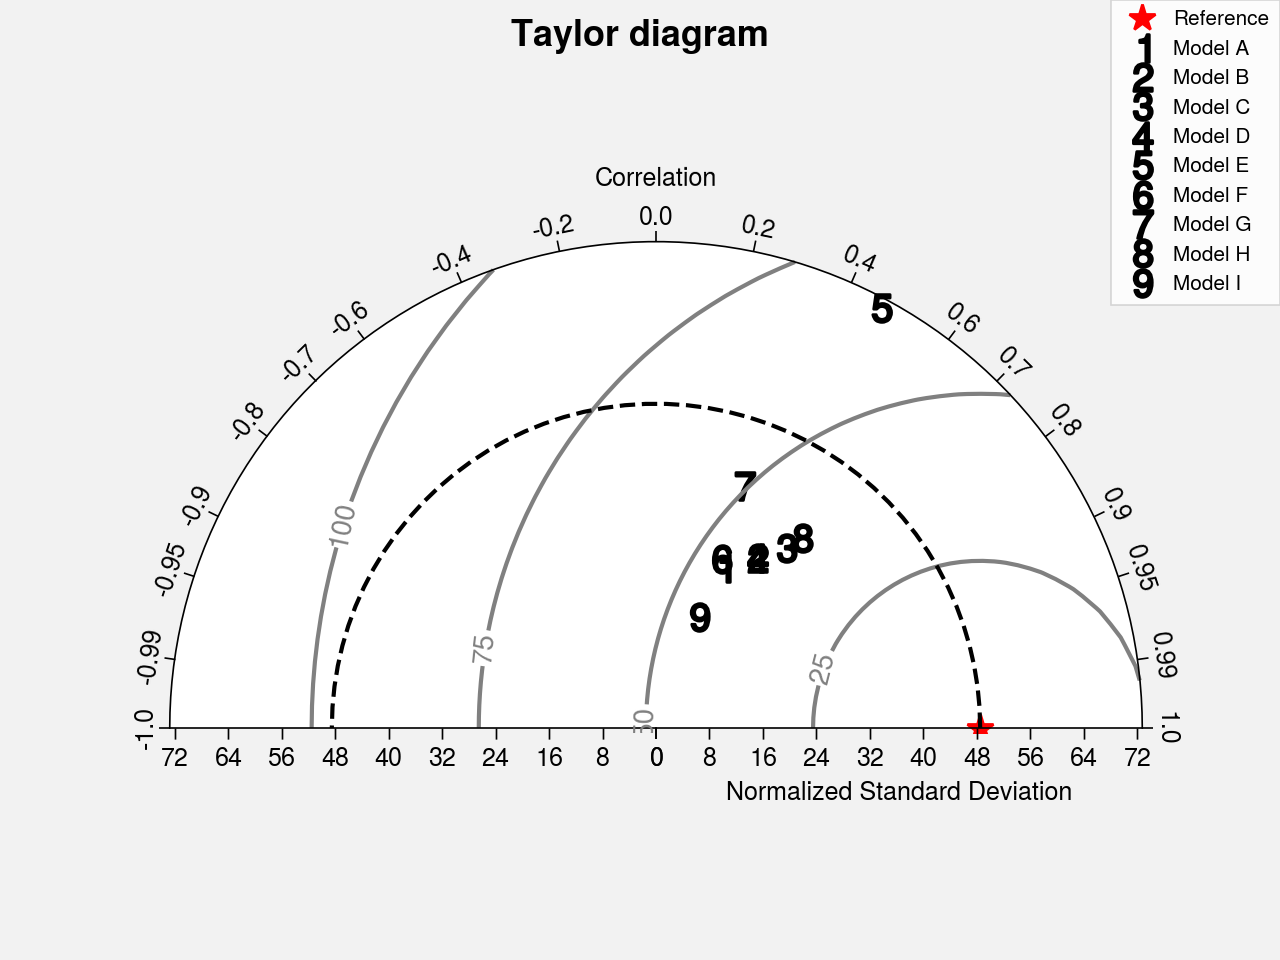

In [43]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Normalized Standard Deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

### Plot

In [7]:
df_station_HMASR_90_1mm

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56223         56434         56444         56533        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  0.30     0.0  5.88     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  0.28     0.0  6.50     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  0.30     0.0  8.70     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  0.30     0.0  7.42     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  0.30     0.0  5.84     0.0   0.0     0.0   0.0   

numb         56543        
product    station HMASR  
date                      
1999-10-01     0.0   0.0  
1999-10-02     0.0   0.0  
1999-10-03     0.0   0.0  
1999-10-04     0.0   0.0  
1999-10-05     0.0   0.0  
...            ...   ...  
2013-12-27     0.0   0.0  
2013-12-28     0.0   0.0  
2013-12-29     0.0   0.0  
2013-12-30     0.0   0.0  
2013-12-31     0.0   0.0  

[5206 rows x 124 columns]

In [ ]:
ts = df_station_HMASR_90_1mm.mean(level='product', axis=1)

mb = (ts.dropna().mean().HMASR - ts.dropna().mean().station)
rmb = (ts.dropna().mean().HMASR - ts.dropna().mean().station)/ts.dropna().mean().station*100
rmse = np.sqrt(((ts.dropna().HMASR - ts.dropna().station)**2).mean())
corr, _ = stats.pearsonr(ts.dropna().HMASR, ts.dropna().station)

In [9]:
index_1mm[0]

'52787'

In [11]:
df_station_HMASR_90_1mm[index_1mm[0]]

product,station,HMASR
date,,
1999-10-01,NaN,0.00
1999-10-02,4.0,0.00
1999-10-03,0.0,0.06
1999-10-04,2.0,0.00
1999-10-05,0.0,0.00
...,...,...
2013-12-27,0.0,0.82
2013-12-28,0.0,0.82
2013-12-29,0.0,0.80


In [15]:
# Compute metrics
std_HMASR = df_station_HMASR_90_1mm[index_1mm[0]].dropna().std().HMASR 
std_station = df_station_HMASR_90_1mm[index_1mm[0]].dropna().std().station 
corr, _ = stats.pearsonr(
    df_station_HMASR_90_1mm[index_1mm[0]].dropna().HMASR, 
    df_station_HMASR_90_1mm[index_1mm[0]].dropna().station
)

In [55]:
df_station_HMASR_90_1mm.groupby(df_station_HMASR_90_1mm.index.month).mean()

numb        52787               52978               56071               56074  \
product   station     HMASR   station     HMASR   station     HMASR   station   
date                                                                            
1        0.638070  3.127143  0.240385  0.668387  0.382270  0.546452  0.681490   
2        1.020904  4.910404  0.429679  0.761717  0.396063  1.027121  0.849326   
3        1.115789  6.252120  0.319512  0.733134  0.487923  0.953410  0.431566   
4        0.660215  1.564429  0.233251  0.176857  0.152415  0.193238  0.310319   
5        0.430073  0.346866  0.035349  0.138433  0.039261  0.137972  0.085782   
6        0.007656  0.070429  0.000000  0.010905  0.007160  0.015667  0.004785   
7        0.000000  0.005115  0.000000  0.000507  0.000000  0.001429  0.000000   
8        0.000000  0.022028  0.000000  0.000092  0.000000  0.004332  0.000000   
9        0.093750  0.383143  0.000000  0.063429  0.000000  0.090762  0.000000   
10       0.896520  1.462452  0.149351  0.379097  0.076078  0.195054  0.143107   
11       0.722943  1.050356  0.139540  0.513022  0.439101  0.170044  0.426316   
12       0.265750  1.834022  0.095614  0.719226  0.107692  0.233161  0.597539   

numb                  56080        ...     56223               56434  \
product     HMASR   station HMASR  ...   station     HMASR   station   
date                               ...                                 
1        2.676912  0.665301   0.0  ...  0.116667  1.528618  0.065574   
2        3.012222  0.969061   0.0  ...  0.185195  2.561970  0.119289   
3        4.506728  0.429293   0.0  ...  0.291566  4.061567  0.180139   
4        1.899333  0.277975   0.0  ...  0.119465  2.537286  0.063723   
5        0.423594  0.078118   0.0  ...  0.000000  0.744608  0.000000   
6        0.207714  0.007160   0.0  ...  0.000000  0.074524  0.000000   
7        0.052350  0.000000   0.0  ...  0.000000  0.008571  0.000000   
8        0.052949  0.000000   0.0  ...  0.000000  0.001889  0.000000   
9        0.295238  0.005115   0.0  ...  0.000000  0.007381  0.000000   
10       1.184903  0.115299   0.0  ...  0.104803  0.096086  0.000000   
11       1.452889  0.446667   0.0  ...  0.073059  0.223289  0.000000   
12       1.637204  0.181507   0.0  ...  0.040043  0.481075  0.267241   

numb                   56444               56533               56543            
product      HMASR   station     HMASR   station     HMASR   station     HMASR  
date                                                                            
1         9.431982  0.390863  0.123594  0.145833  0.000922  1.245238  1.649677  
2        26.206515  0.880759  0.671364  0.262755  0.000152  1.680628  1.654192  
3        24.067880  1.357531  0.160876  0.173210  0.000000  0.718377  0.451152  
4         9.178810  0.304478  0.038238  0.004785  0.000000  0.045673  0.263810  
5         1.809309  0.011574  0.003917  0.000000  0.000000  0.000000  0.043456  
6         0.130000  0.000000  0.000000  0.000000  0.000000  0.000000  0.001619  
7         0.014101  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8         0.002120  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9         0.001095  0.000000  0.000143  0.000000  0.000000  0.000000  0.001524  
10        0.000688  0.036797  0.012301  0.000000  0.000000  0.006479  0.030624  
11        0.053822  0.394144  0.016222  0.000000  0.000000  0.147651  0.018800  
12        0.678452  0.080087  0.006065  0.000000  0.000000  0.088937  0.173462  

[12 rows x 124 columns]

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


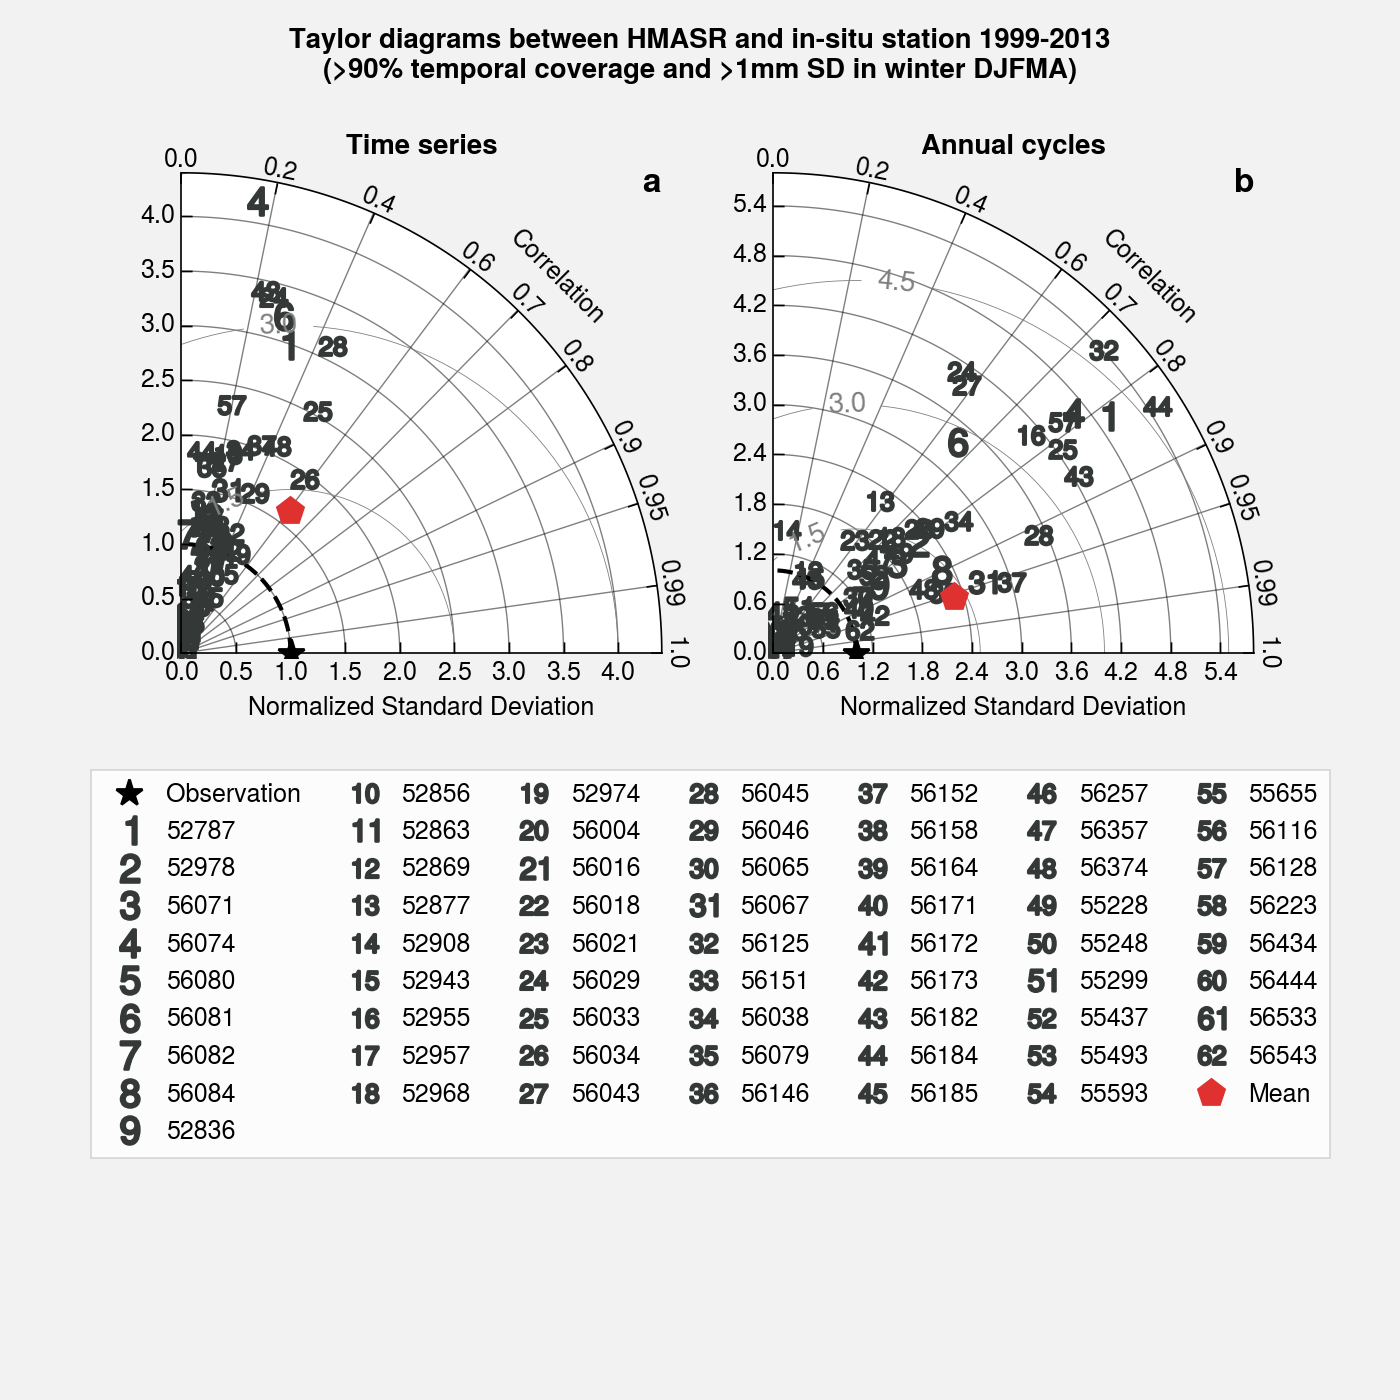

In [136]:
list_var = ['tas', 'pr', 'snc']
list_label = ['Temperature', 'Precipitation', 'Snow cover']
rects = [221, 222]
abc = ['a', 'b', 'c']
srange = [(0, 4.4), (0, 5.8)]
color='charcoal'

fig = plt.figure(figsize=(7,7))

###################
### Time series ###
###################

dia = TaylorDiagram(1, fig=fig, rect=rects[0], label='Observation', srange=srange[0], extend=False)

for i, index in enumerate(index_1mm):
    
    # Compute metrics
    std_HMASR = df_station_HMASR_90_1mm[index].dropna().std().HMASR 
    std_station = df_station_HMASR_90_1mm[index].dropna().std().station 
    corr, _ = stats.pearsonr(
        df_station_HMASR_90_1mm[index].dropna().HMASR, 
        df_station_HMASR_90_1mm[index].dropna().station
    )
    
    dia.add_sample(std_HMASR/std_station, corr, marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=color, mec=color, label=index)

# Mean
ts = df_station_HMASR_90_1mm.mean(level='product', axis=1)

std_HMASR = ts.dropna().std().HMASR 
std_station = ts.dropna().std().station 
corr, _ = stats.pearsonr(ts.dropna().HMASR, ts.dropna().station)

dia.add_sample(std_HMASR/std_station, corr, marker='p', ms=10, ls='', mfc='red8', mec='red8', label='Mean')

# Format
dia._ax.set_title('Time series', fontweight="bold")
dia._ax.text(0.95, 0.95, abc[0], size=12, weight='bold', transform=dia._ax.transAxes)

# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5', linewidths=0.3)  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

# Grid
dia._ax.grid(lw=0.5, alpha=0.5)



####################
### Annual cycle ###
####################

dia = TaylorDiagram(1, fig=fig, rect=rects[1], label='Observation', srange=srange[1], extend=False)

ac = df_station_HMASR_90_1mm.groupby(df_station_HMASR_90_1mm.index.month).mean()

for i, index in enumerate(index_1mm):
    
    # Compute metrics
    std_HMASR = ac[index].dropna().std().HMASR 
    std_station = ac[index].dropna().std().station 
    corr, _ = stats.pearsonr(
        ac[index].dropna().HMASR, 
        ac[index].dropna().station
    )
    
    dia.add_sample(std_HMASR/std_station, corr, marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=color, mec=color, label=index)

# Mean
ts = ac.mean(level='product', axis=1)

std_HMASR = ts.dropna().std().HMASR 
std_station = ts.dropna().std().station 
corr, _ = stats.pearsonr(ts.dropna().HMASR, ts.dropna().station)

dia.add_sample(std_HMASR/std_station, corr, marker='p', ms=10, ls='', mfc='red8', mec='red8', label='Mean')

# Format
dia._ax.set_title('Annual cycles', fontweight="bold")
dia._ax.text(0.95, 0.95, abc[1], size=12, weight='bold', transform=dia._ax.transAxes)

# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5', linewidths=0.3)  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

# Grid
dia._ax.grid(lw=0.5, alpha=0.5)


##############
### Legend ###
##############

fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, bbox_to_anchor=(0.95, 0.45), ncol=7)

plt.suptitle('Taylor diagrams between HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD in winter DJFMA)')

# fig.tight_layout()

# fig.savefig('img/taylor_diagram_1999-2013.jpg', dpi=300)

### Scatter plot of time series

In [185]:
HMASR = []
station = []

# Concatenate all values from all stations time series (daily)
for i, index in enumerate(index_1mm):
    HMASR.append(list(df_station_HMASR_90_1mm[index].HMASR.values))
    station.append(list(df_station_HMASR_90_1mm[index].station.values))

HMASR_TS_all = np.concatenate(HMASR)
station_TS_all = np.concatenate(station)

# Remove NaN's values
HMASR_TS_all = HMASR_TS_all[~np.isnan(station_TS_all)]
station_TS_all= station_TS_all[~np.isnan(station_TS_all)]

# Mean
HMASR_TS_mean = df_station_HMASR_90_1mm.mean(level='product', axis=1).dropna().HMASR
station_TS_mean = df_station_HMASR_90_1mm.mean(level='product', axis=1).dropna().station

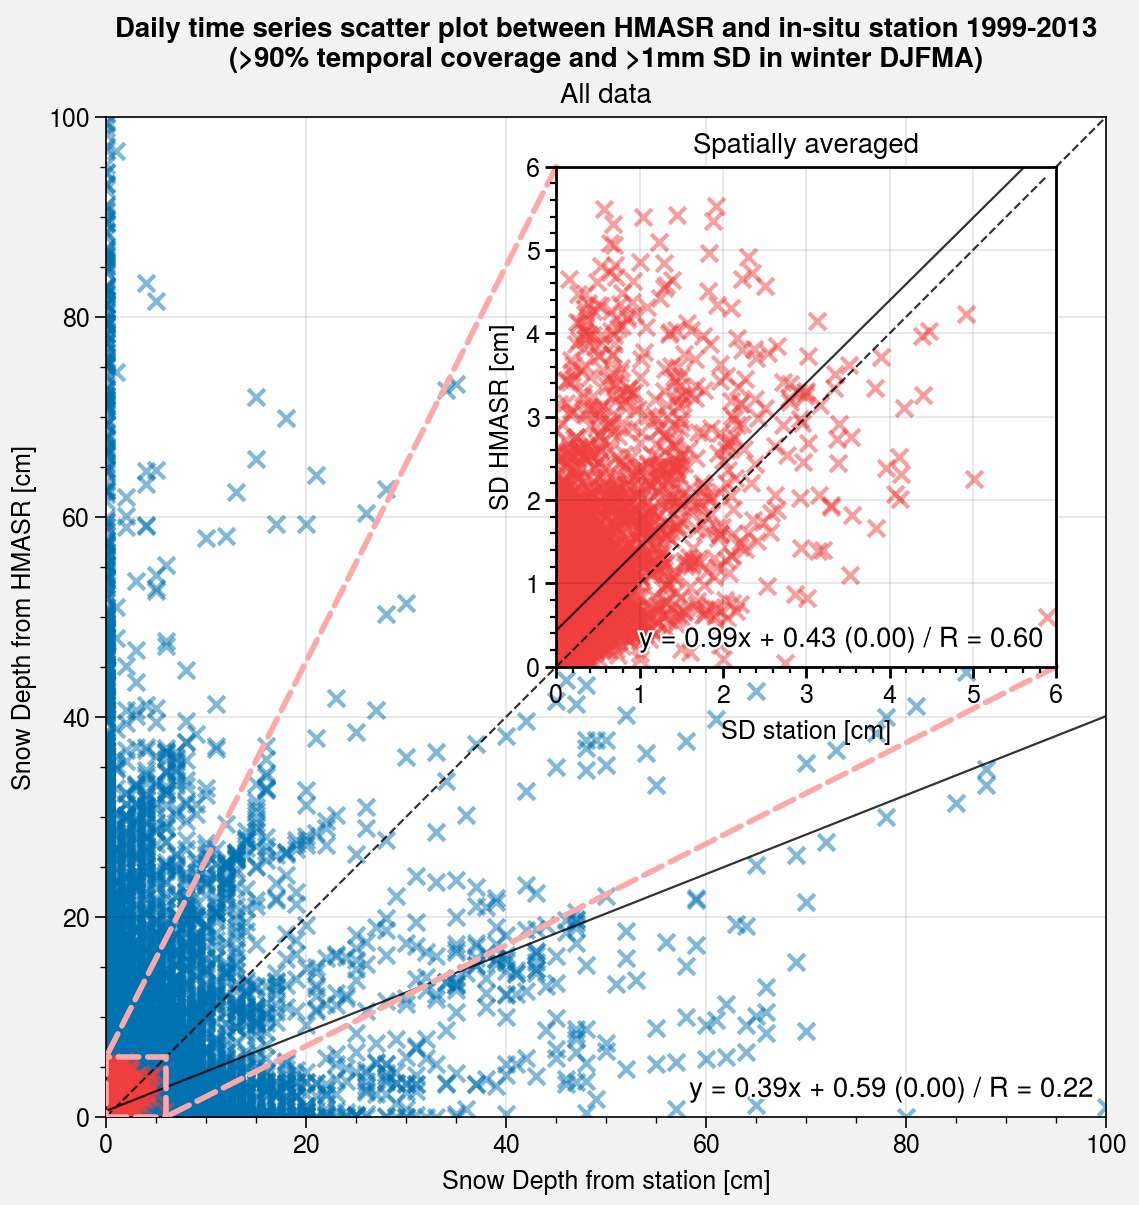

In [217]:
fig, axs = plot.subplots(axwidth=5)


#######################
### Plot all points ###
#######################
axs[0].scatter(station_TS_all, HMASR_TS_all, marker='x', alpha=0.5)

# Make linear trend for models values
reg = stats.linregress(station_TS_all, HMASR_TS_all)
x = np.array([0, np.max(station_TS_all)])
y = reg.slope*x + reg.intercept
axs[0].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
axs[0].plot(x, x, 'k--', linewidth=0.8, alpha=0.8)
axs[0].format(
    lrtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)) + ' (%.2f)' % round(reg.pvalue, 2) +\
            ' / R = %.2f' % round(reg.rvalue, 2)
)


#################
### Plot mean ###
#################
axs[0].scatter(station_TS_mean, HMASR_TS_mean, marker='x', alpha=0.5, color='red7')

############
### Zoom ###
############
ix = axs[0].inset(
    [45, 45, 50, 50], transform='data', zoom=True,
    zoom_kw={'edgecolor': 'red3', 'lw': 2, 'ls': '--'}
)
ix.format(
    xlim=(0, 6), ylim=(0, 6), color='k',
    linewidth=1, ticklabelweight='normal',
    xlabel='SD station [cm]',
    ylabel='SD HMASR [cm]',
    title='Spatially averaged'
)
ix.scatter(station_TS_mean, HMASR_TS_mean, marker='x', alpha=0.5, color='red7')

# Make linear trend for models values
reg = stats.linregress(station_TS_mean, HMASR_TS_mean)
x = np.array([0, np.max(station_TS_mean)])
y = reg.slope*x + reg.intercept
ix.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
ix.plot(x, x, 'k--', linewidth=0.8, alpha=0.8)
ix.format(
    lrtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)) + ' (%.2f)' % round(reg.pvalue, 2) +\
            ' / R = %.2f' % round(reg.rvalue, 2)
)


axs[0].format(
    xlabel='Snow Depth from station [cm]',
    ylabel='Snow Depth from HMASR [cm]',
    suptitle='Daily time series scatter plot between HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD in winter DJFMA)',
    title='All data',
    xlim=(0, 100), ylim=(0, 100)
)

# fig.savefig('img/scatter_plot_TS_1999-2013.jpg', dpi=300)